In [1]:
import numpy as np
import pandas as pd

patients = pd.read_csv('internacoes_charlson_zero.csv.gz', compression='gzip', nrows=None, usecols=['target'])
target = np.asarray(patients['target'].values)
print(target.shape)

(48907,)


In [2]:
import nltk
nltk.download('rslp')
nltk.download('stopwords')

[nltk_data] Downloading package rslp to /home/ubuntu/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import gzip, pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

import nltk.stem
portuguese_stemmer = nltk.stem.RSLPStemmer()


class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer,self).build_analyzer()
        return lambda doc: (portuguese_stemmer.stem(w) for w in analyzer(doc))

with gzip.open('model_10k_multigram.pkl.gz', 'rb') as rpk:
    tfidf_model = pickle.load(rpk)
    rpk.close()
    
with gzip.open('data_10k_multigram.npy.gz', 'rb') as rpk:
    data = pickle.load(rpk)
    rpk.close()

print(data.shape)

(48907, 10000)


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [34]:
split_kfold = StratifiedKFold(n_splits=20)
for trash, used in split_kfold.split(patients.index.values, target):
    break
    
target_set = target
data_set = data

kfold = StratifiedKFold(n_splits=6)

values = []
prediction = []
models = []
maes = []

for train, test in kfold.split(data_set, target_set):

    model = RandomForestRegressor(n_jobs=16)
    
    model.fit(data_set[train], target_set[train])
    target_pred = model.predict(data_set[test])
    mae = mean_absolute_error(target_set[test], target_pred)
    
    values.extend(target_set[test])
    prediction.extend(target_pred)
    maes.append(mae)
    models.append(model)

    print('mean_absolute_error: ', mae)
    
print(np.mean(maes))

mean_absolute_error:  1.1377404729812524
mean_absolute_error:  1.1959784207945072
mean_absolute_error:  1.3386851465718141
mean_absolute_error:  1.3841801669121256
mean_absolute_error:  1.7054143646408837
mean_absolute_error:  1.8778241650294696
1.4399704561550088


In [35]:
tuples = np.stack((values,np.round(prediction,1)), axis=-1) ## ROUND TUPLES

frequencies = {}
for x,y in tuples:
    key = (x, y)
    if key in frequencies:
        frequencies[key] += 1
    else:
        frequencies[key] = 1

size = []
x = []
y = []
for key in frequencies.keys():
    size.append(frequencies[key])
    x.append(key[0])
    y.append(key[1])

In [36]:
np.max(values), np.max(x), np.max(y)

(23.0, 23.0, 13.0)

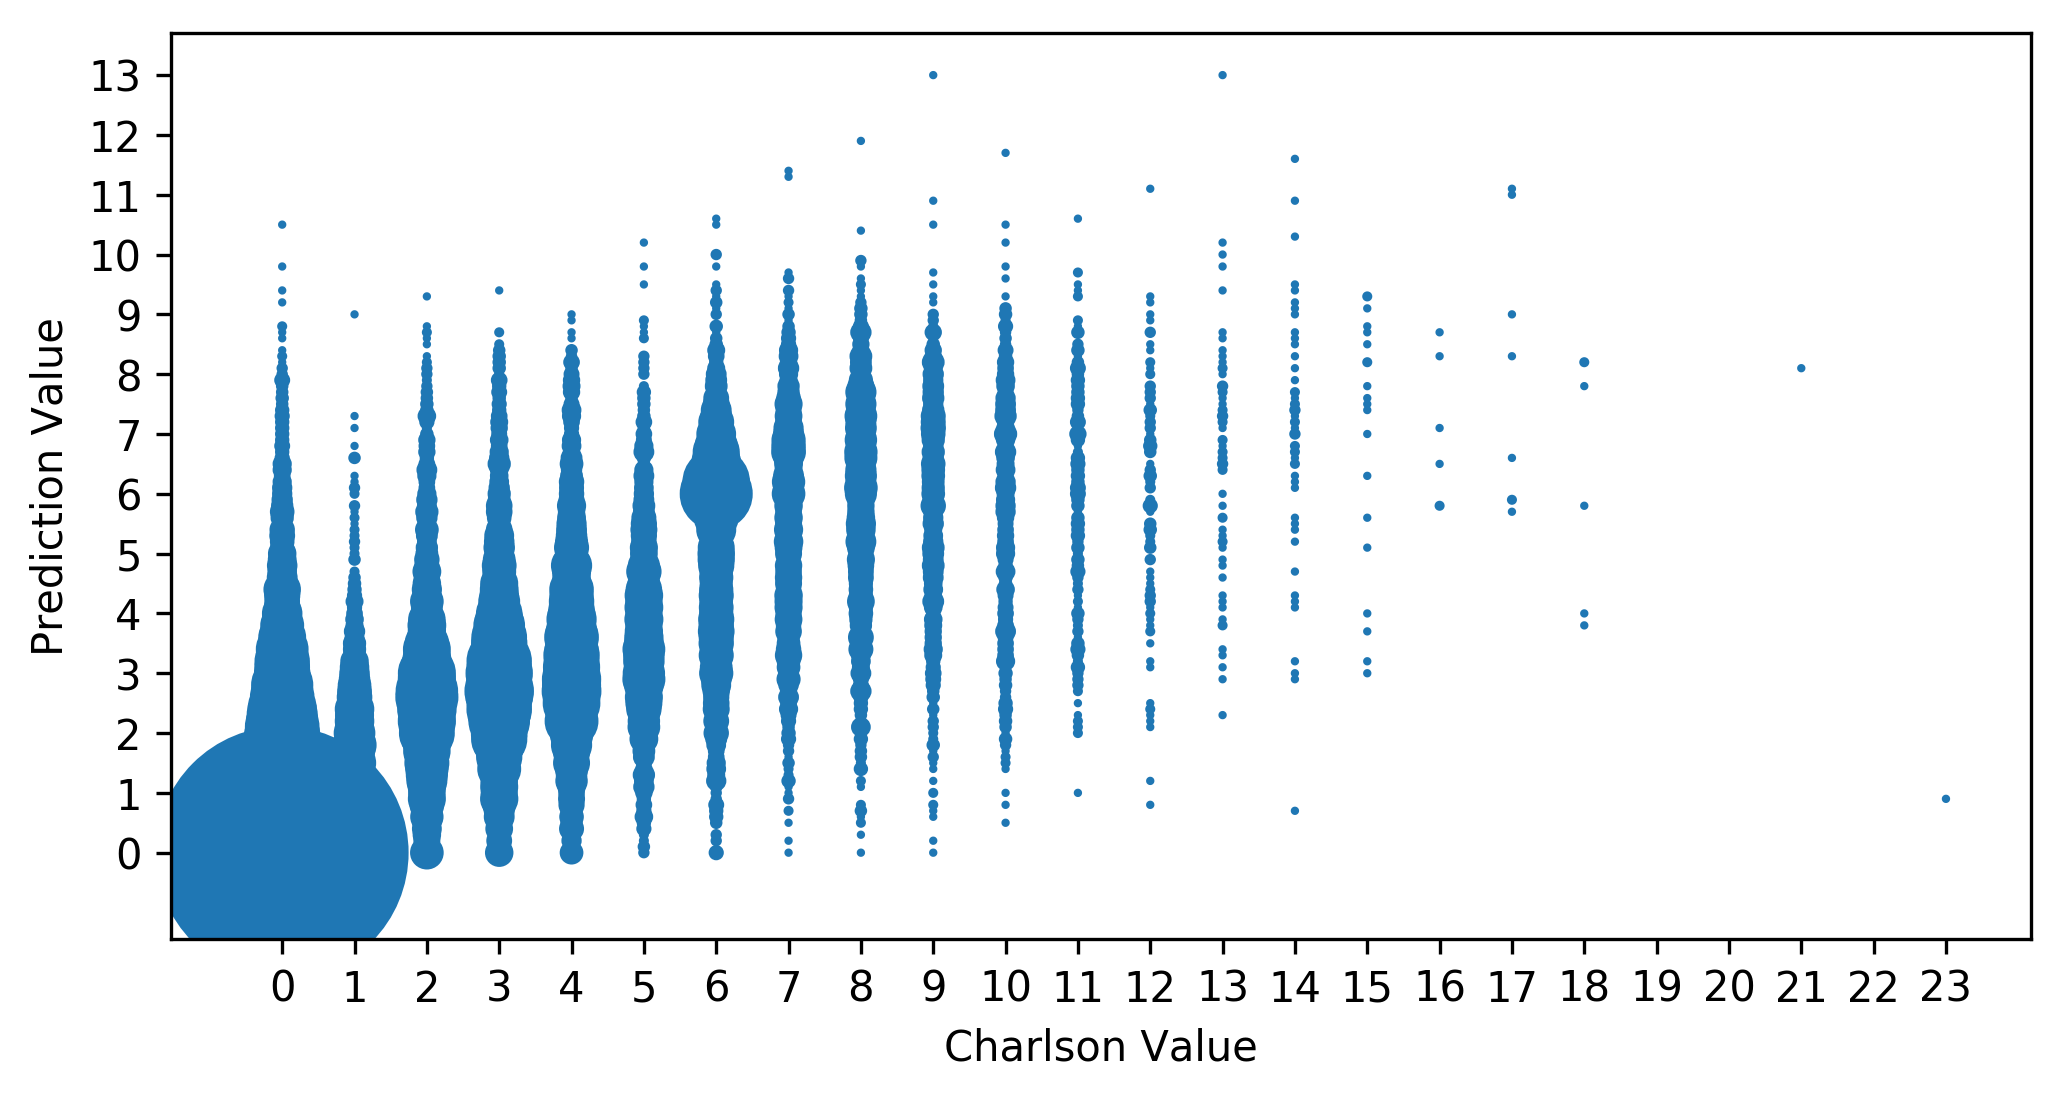

In [37]:
# https://matplotlib.org/gallery/shapes_and_collections/scatter.html
%matplotlib inline
import matplotlib.pyplot as plt

maxX = np.max(x)

plt.figure(figsize=(8, 4), dpi= 300)
plt.xlabel('Charlson Value', fontsize=10)
plt.ylabel('Prediction Value', fontsize=10)
plt.xticks(range(int(maxX)+1))
plt.yticks(range(int(maxX)+1))

plt.scatter(x,y,s=size)
plt.show()

In [38]:
import operator
import sys

In [39]:
features = {}
ridx = {idx:term for term,idx in tfidf_model.vocabulary_.items()}
for model in models:
    for i,v in enumerate(model.feature_importances_):
        if not ridx[i] in features.keys():
            features[ridx[i]] = v
        else:
            features[ridx[i]] += v
        if (i % 1000) == 0:
            sys.stdout.write(str(i) + ', ')
            sys.stdout.flush()

0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 

In [40]:
sorted(features.items(), key=operator.itemgetter(1), reverse=True)[:20]

[('oncolog', 0.7985902298860339),
 ('doenca virus imunodeficienc', 0.44180296024365606),
 ('doenca viru', 0.2951752645491537),
 ('insulin', 0.21756235666403106),
 ('malign', 0.1929042631474716),
 ('pali', 0.1288326406398),
 ('cd4', 0.09104547970978777),
 ('cirros', 0.08354340421140377),
 ('dor abdom', 0.07945408925610867),
 ('estad', 0.07447504412889232),
 ('irc', 0.07126479466253897),
 ('isquem', 0.06044622358444048),
 ('avc', 0.05804756766365908),
 ('neoplas', 0.05619551289175893),
 ('metastá', 0.04857504300303062),
 ('beg', 0.04483131604928169),
 ('dm', 0.03766168031856803),
 ('dpoc', 0.03590425065669788),
 ('diabet', 0.03390476241739703),
 ('icc', 0.030927580597965184)]